# Group Assignment: Your Own Analysis
## Name: Darshika Verma

#### 1. This assignment consists of two parts. You will work in groups to complete the assignment.

**Data Source**

- What data source are you using for this project?

**Problem or Question**

- What question or hypothesis do you want to answer with your subtitles?

**Answer the Question**

- You can use any analysis we have done in class, extend to a new analysis type, or expand a previous analysis. In this section, explain how you will answer the question you proposed above.

#### 2. Then you will be manually assigned to do a peer review (so you don't get your own group!).
- You will complete the peer review portion of the assignment by giving feedback on the group you've been assigned.
- To complete the feedback, please answer the following questions:
  - Is the assignment complete?
  - Does the problem/question relate to the topics we have covered in this class?
  - Does their proposed analysis answer their problem question?
  - Any other feedback relevant to their proposed project?

#### 3. The Peer Reviews are worth 25 points as part of the assignment.
Peer reviews are anonymous, only the instructor can see who you are.

# Loading Libraries

In [21]:
import os
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import spacy
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
nlp = spacy.load('en_core_web_sm')
from nltk.sentiment import SentimentIntensityAnalyzer
from IPython.display import display, HTML
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import BartTokenizer, BartForConditionalGeneration
import torch
import subprocess
print(subprocess.getoutput("python -m spacy download en_core_web_sm"))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 56.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# 1. Data Source

Data Source : https://fangj.github.io/friends/

I fetched and parsed the text content of multiple webpages containing subtitles from the TV show "Friends" (Episode 1-12 of Season 1),  accumulating the texts into a complete string and a list of paragraphs.

# 2. Import data

In [22]:
# List of URLs to scrape
urls = [
    'https://fangj.github.io/friends/season/0101.html',
    'https://fangj.github.io/friends/season/0102.html',
    'https://fangj.github.io/friends/season/0103.html',
    'https://fangj.github.io/friends/season/0104.html',
    'https://fangj.github.io/friends/season/0105.html',
    'https://fangj.github.io/friends/season/0106.html',
    'https://fangj.github.io/friends/season/0107.html',
    'https://fangj.github.io/friends/season/0108.html',
    'https://fangj.github.io/friends/season/0109.html',
    'https://fangj.github.io/friends/season/0110.html',
    'https://fangj.github.io/friends/season/0111.html',
    'https://fangj.github.io/friends/season/0112.html'
    ]

# Function to fetch and parse a webpage, and return its text content
def fetch_page_text(urls):
    complete_text = ""  # Initialize empty string to accumulate text
    textList = []  # Initialize empty list to store paragraph texts
    for url in urls:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            text_content = soup.find_all('p')
            paragraphs = [paragraph.text for paragraph in text_content]
            textList.extend(paragraphs)
            complete_text += " ".join(paragraphs) + "\n\n"  # Add to complete_text with separation
        else:
            print(f"Failed to retrieve the webpage {url}. Status code: {response.status_code}")
    return complete_text, textList

# Call the function to fetch page texts
complete_text, textList = fetch_page_text(urls)

# Print the complete text (first 1000 characters)
print("First 1000 characters of complete_text:")
print(complete_text[:1000])

# Print the textList
print("\nContents of textList:")
print(textList)

# Tokenize the text
tokens = word_tokenize(complete_text)

# Display the number of tokens
print("Number of tokens in the text:", len(tokens))

First 1000 characters of complete_text:
Written by: Marta Kauffman & David Crane  Monica: There's nothing to tell! He's just some guy
I work with! Joey: C'mon, you're going out with the guy! There's
gotta be something wrong with him! Chandler: All right Joey, be
nice.  So does he have a hump? A hump and a hairpiece? Phoebe: Wait, does he eat chalk? (They all stare, bemused.) Phoebe: Just, 'cause, I don't want her to go through
what I went through with Carl- oh! Monica: Okay, everybody relax. This is not even a
date. It's just two people going out to dinner and- not having sex. Chandler: Sounds like a date to me. [Time Lapse] Chandler: Alright, so I'm back in high school, I'm
standing in the middle of the cafeteria, and I realize I am totally naked. All: Oh, yeah. Had that dream. Chandler: Then I look down, and I realize there's a
phone... there. Joey: Instead of...? Chandler: That's right. Joey: Never had that dream. Phoebe: No. Chandler: All of a sudden, the phone starts to ring.
Now 

# 3. Fix Errors
- Examine the text for errors or problems by looking at the text.
- Clean the data with examples from class

Filtering out certain values, dropping rows with empty values, resulting in a cleaned DataFrame ready for further analysis (manual cleaning).

In [23]:
df = pd.DataFrame(textList, columns = ['Subtitle'])
df['Subtitle'] = df['Subtitle'].replace('Written by: Marta Kauffman & David Crane', np.nan)
df['Subtitle'] = df['Subtitle'].str.replace(r'\(.*?\)', '', regex=True)
values_to_remove = ['Opening Credits', 'Commercial Break', 'End', 'Closing Credits']
df = df[~df['Subtitle'].isin(values_to_remove)]
df = df.replace('', np.nan).dropna().reset_index(drop=True)

I have written a function that simultaneously cleans text (cleanup function) and calculates impurity scores (impurity score function). This function computes two scores for each row in the dataset: 'Initial_Impurity_Score' before cleaning and 'Post_Cleaning_Impurity_Score' after cleaning. It's important to note that after applying the cleanup function, some rows that were initially less clean have their impurity score reduced to 0.0. I have also created a column below 'Cleaned_Subtitle' which eventually displays clean rows (implemented cleanup fucntion).

In [24]:
import re
import pandas as pd
import html

# Define the regular expression pattern
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(lst):
    """Returns the share of suspicious characters in a text."""
    if len(lst) < 1:
        return 0
    _sum = 0
    for i in range(len(lst)):
        try:
            _sum += len(RE_SUSPICIOUS.findall(lst[i])) / len(lst[i]) #2/5
        except:
            pass
    return _sum

# Define the clean_up function
def clean_up(text):
    # Convert HTML escapes like &amp; to characters.
    text = html.unescape(text)
    # Remove HTML tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # Remove markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # Remove text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # Remove standalone sequences of specials
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # Remove standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # Remove punctuation and parentheses
    text = re.sub(r'[,\.\(\)-]', '', text)
    # Remove sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Apply the impurity function to the 'Subtitle' column before cleaning
df['Initial_Impurity_Score'] = df['Subtitle'].apply(lambda x: impurity([x]))

# Apply the clean_up function to the 'Subtitle' column
df['Cleaned_Subtitle'] = df['Subtitle'].apply(clean_up)
# Apply the impurity function to the 'Cleaned_Subtitle' column after cleaning
df['Post_Cleaning_Impurity_Score'] = df['Cleaned_Subtitle'].apply(lambda x: impurity([x]))
df = df.replace('', np.nan).dropna().reset_index(drop=True)
# Display the DataFrame
df[['Cleaned_Subtitle','Post_Cleaning_Impurity_Score']].head(5)

,Cleaned_Subtitle,Post_Cleaning_Impurity_Score
0,Monica: There's nothing to tell! He's just som...,0.0
1,Joey: C'mon you're going out with the guy! The...,0.0
2,Chandler: All right Joey be nice So does he ha...,0.0
3,Phoebe: Wait does he eat chalk?,0.0
4,Phoebe: Just 'cause I don't want her to go thr...,0.0


In [25]:
columns_to_drop = ['Subtitle', 'Initial_Impurity_Score', 'Post_Cleaning_Impurity_Score']
df.drop(columns=columns_to_drop, inplace=True)
new_column_name = 'Subtitle'
df.rename(columns={'Cleaned_Subtitle': new_column_name}, inplace=True)
df_sentences = df

In [26]:
# Create an empty DataFrame to store pairs
paired_df = pd.DataFrame(columns=['Sentence', 'Person1', 'Person2'])

pairs = []

# Extracting and pairing subtitles
subtitles = df_sentences['Subtitle'].tolist()

for i in range(0, len(subtitles) - 1, 2):
    try:
        person1, text1 = subtitles[i].split(":", 1)
        person2, text2 = subtitles[i + 1].split(":", 1)
        pairs.append({
            'Sentence': subtitles[i] + " " + subtitles[i + 1],
            'Person1': person1.strip(),
            'Person2': person2.strip()
        })
    except ValueError:
        # Skip the iteration if splitting fails (i.e., not enough values to unpack)
        continue

# Handle cases where there is an odd number of subtitles
if len(subtitles) % 2 != 0:
    try:
        person1, text1 = subtitles[-1].split(":", 1)
        pairs.append({
            'Sentence': subtitles[-1],
            'Person1': person1.strip(),
            'Person2': ''
        })
    except ValueError:
        # Handle the last subtitle if it does not contain a colon
        pairs.append({
            'Sentence': subtitles[-1],
            'Person1': subtitles[-1].strip(),
            'Person2': ''
        })

# Convert list of pairs to DataFrame
paired_df = pd.DataFrame(pairs)

#ent_sentences = paired_df[(paired_df['Person1'] == "Ross")|(paired_df['Person2'] == "Ross")]
ent_sentences = paired_df
df = paired_df #remove this later#2
ent_sentences.head()

,Sentence,Person1,Person2
0,Monica: There's nothing to tell! He's just som...,Monica,Joey
1,Chandler: All right Joey be nice So does he ha...,Chandler,Phoebe
2,Phoebe: Just 'cause I don't want her to go thr...,Phoebe,Monica
3,Chandler: Sounds like a date to me Chandler: A...,Chandler,Chandler
4,All: Oh yeah Had that dream Chandler: Then I l...,All,Chandler


In [27]:
# Function to clean sentences
def clean_sentence(sentence):
    # Find the position of the second ':'
    second_colon_index = sentence.find(':', sentence.find(':') + 1)
    if second_colon_index != -1:
        # Keep only the part before the second colon
        cleaned_sentence = sentence[:second_colon_index]
    else:
        cleaned_sentence = sentence  # If second ':' not found, return the original sentence

    # Remove the last word from the cleaned sentence
    cleaned_sentence = ' '.join(cleaned_sentence.split()[:-1])

    return cleaned_sentence.strip()  # Strip any leading/trailing whitespace

# Clean the 'Sentence' column
df['Sentence'] = df['Sentence'].apply(clean_sentence)

# Display the updated dataframe
df.drop(columns=['Person2'], inplace=True)
df.rename(columns={'Person1': 'Person'}, inplace=True)

# Remove the text before the colon ":" in the "Sentence" column
df["Sentence"] = df["Sentence"].apply(lambda x: x.split(": ", 1)[1] if ": " in x else x)
df = df[~df['Person'].isin(['Woman','All','Phoebe Ross Chandler and Joey','Priest on TV','The Guys','Guys','Monica and Phoebe','Both','Kid',
                            'Director','Written by','Fun Bobby','Coma Guy','Joey Chandler and Ross', 'Rachel and Phoebe', 'Girls',
       'Joey and Chandler','[Scene'])]
df = df[df['Sentence'].str.len() > 45]
df.head()

,Sentence,Person
0,There's nothing to tell! He's just some guy I ...,Monica
1,All right Joey be nice So does he have a hump?...,Chandler
2,Just 'cause I don't want her to go through wha...,Phoebe
7,All of a sudden the phone starts to ring Now I...,Chandler
8,Finally I figure I'd better answer it and it t...,Chandler


In [28]:
df.head()

,Sentence,Person
0,There's nothing to tell! He's just some guy I ...,Monica
1,All right Joey be nice So does he have a hump?...,Chandler
2,Just 'cause I don't want her to go through wha...,Phoebe
7,All of a sudden the phone starts to ring Now I...,Chandler
8,Finally I figure I'd better answer it and it t...,Chandler


### Having already implemented techniques such as NER, Information Extraction, Knowledge Graphs, and Text Summarization (using TextRank, LDA, and LSA) in previous assignments, I focused my analysis on Character Sentiment Analysis with the VART model, and improving the accuracy of the VART model by using an SVM with TF-IDF feature extraction and Text Summarization using BART model.

# Question - 1: I aim to analyze the sentiment in the subtitle of the TV show "Friends" to understand character dynamics and interactions. To achieve this, I need to identify the most useful features of the dialogues. This can be done by comparing the frequencies of different type of features in the subtitles and evaluating different sentiment analysis approach.

### **RQ1: Do the characters in "Friends" use positive sentiment words more frequently in their dialogues?**
### **RQ2: Do antagonistic or conflict scenes in "Friends" feature a higher frequency of negative sentiment words?**

# **RQ1: Do the characters in "Friends" use positive sentiment words more frequently in their dialogues?**

I utilized the **VADER** model to assess the sentiment of characters as they delivered their dialogues. For visualization, I employed heatmaps and the **WordCloud** library to illustrate the sentiments. Additionally, I evaluated the accuracy of the VADER model against a manually labeled dataset, categorizing sentiments as Positive, Negative, and Neutral.

**VADER (Valence Aware Dictionary and sentiment Reasoner)**
  - Uses a pre-built dictionary where each word or phrase is assigned a sentiment score, for example, "happy" might have a positive score, while "sad" has a negative score.
  - VADER also considers modifiers like "very" or "not," which can change the intensity of the sentiment. For example, "very happy" would be more positive than just "happy," and "not happy" would be negative.
  - VADER then combines the scores of all words in a text to compute an overall sentiment score.

**Implementation of VADER on my text :**

1. **Sentiment Analysis VADER Model:** I used the VADER sentiment analysis model to compute sentiment scores of each character based on the words they used while they are delivering their dialogues. The sentiment scores helped classify each dialogue as Positive, Negative, or Neutral.
  - I applied the `SentimentIntensityAnalyzer` from the VADER model to each dialogue in the dataset to obtain sentiment scores. I used the function `comp_score` to get the compound score and added it to the DataFrame.
  -  I used the `color_sentiment` function to color-code words based on their sentiment (green for positive, red for negative, black for neutral). This enhanced the readability of sentiment in each dialogue.

2. **Visualization:**
  - **Color-coded Sentences:** I aimed to visually distinguish positive, negative, and neutral words in each dialogue for better readability. For this, I created `Sentence_colored` column, which contains HTML-formatted sentences with color-coded words based on their sentiment scores.
  - **Word Clouds:** All the words tagged as negative by the VADER model as colored as red, whereas positive words are colored as green using the `WordCloud` library.

3. **Evaluated Model Accuracy:** I compared the sentiment labels generated by the VADER model with manually labeled sentiments in the dataset.
  - **Calculated Accuracy:** I computed the accuracy of the VADER model by comparing its sentiment predictions with the manually labeled data.
  - **Generated Classification Report and Confusion Matrix:** I created a classification report and confusion matrix to assess the performance of the VADER model, using metrics such as precision, recall, and F1-score.



## 1.1 VADER MODEL

In [29]:
# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

#Sentiment Score
def comp_score(text):
  return sia.polarity_scores(text)['compound']
df['Sentiment_score'] =  df['Sentence'].apply(comp_score)

# Function to color code based on sentiment score
def color_sentiment(word, sentiment_score):
    if sentiment_score >= 0.05:
        return f'<span style="color: green;">{word}</span>'  # Positive sentiment
    elif sentiment_score <= -0.05:
        return f'<span style="color: red;">{word}</span>'    # Negative sentiment
    else:
        return f'<span style="color: black;">{word}</span>' # Neutral sentiment

# Function to analyze sentiment of a subtitle
def analyze_subtitle(subtitle):
    words = subtitle.split()
    colored_subtitle = []

    for word in words:
        sentiment_score = sia.polarity_scores(word)['compound']
        colored_word = color_sentiment(word, sentiment_score)
        colored_subtitle.append(colored_word)

    return ' '.join(colored_subtitle)

# Function to label sentiment based on sentiment score
def label_sentiment(sentiment_score):
    if sentiment_score >= 0.05:
        return 'Positive'  # Positive sentiment
    elif sentiment_score <= -0.05:
        return 'Negative'  # Negative sentiment
    else:
        return 'Neutral'   # Neutral sentiment

# Function to analyze and label the sentiment of a sentence
def analyze_sentence(sentence):
    sentiment_score = sia.polarity_scores(sentence)['compound']
    return label_sentiment(sentiment_score)


# Apply the sentiment analysis to each sentence
df['Sentence_colored'] = df['Sentence'].apply(analyze_subtitle)
df['Sentiment'] = df['Sentence'].apply(analyze_sentence)

# Display the DataFrame with the new sentiment column using HTML for colored text
def render_html(df):
    return HTML(df.to_html(escape=False))

# Display the DataFrame
display(render_html(df[['Sentence_colored','Person','Sentiment_score','Sentiment']].head()))

,Sentence_colored,Person,Sentiment_score,Sentiment
0,There's nothing to tell! He's just some guy I work with!,Monica,0.0000,Neutral
1,All right Joey be nice So does he have a hump? A hump and a hairpiece?,Chandler,0.4871,Positive
2,Just 'cause I don't want her to go through what I went through with Carl oh!,Phoebe,-0.1316,Negative
7,All of a sudden the phone starts to ring Now I don't know what to do everybody starts looking at me,Chandler,0.0000,Neutral
8,Finally I figure I'd better answer it and it turns out it's my mother which is veryvery weird because she never calls me!,Chandler,0.3595,Positive


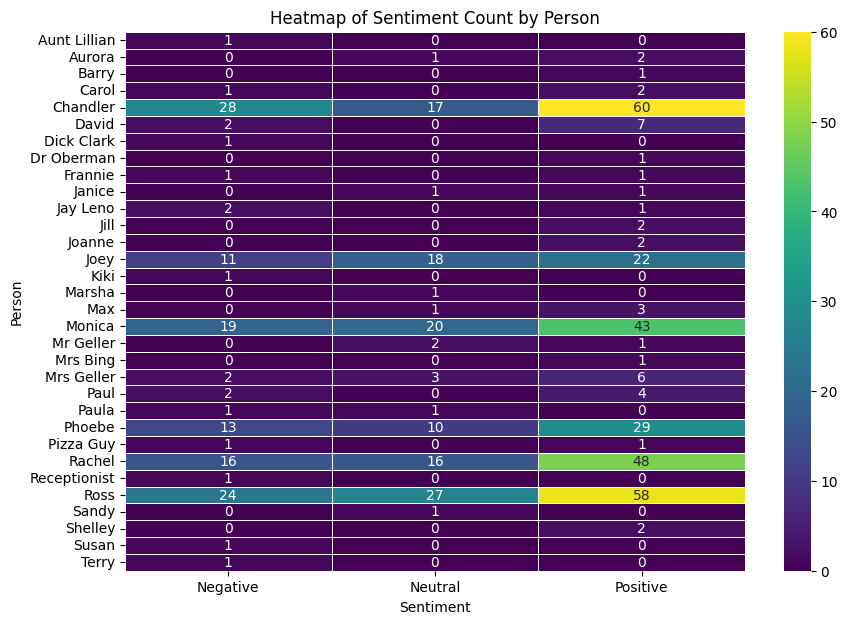

In [30]:
sentiment_count = df.groupby(['Person', 'Sentiment']).size().unstack(fill_value=0)
# Plotting a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(sentiment_count, annot=True, cmap='viridis', cbar=True, linewidths=0.5)
plt.xlabel('Sentiment')
plt.ylabel('Person')
plt.title('Heatmap of Sentiment Count by Person')
plt.show()

#### The heatmap shows the sentiment distribution (Negative, Neutral, Positive) for various characters. Chandler has the highest number of positive sentiments (60), followed by Ross (58) and Rachel (48). Negative sentiments are relatively low across all characters, with Chandler having the most (28). Monica and Joey exhibit a balanced sentiment distribution, with significant counts in neutral and positive categories.

## 1.2 WORD CLOUD

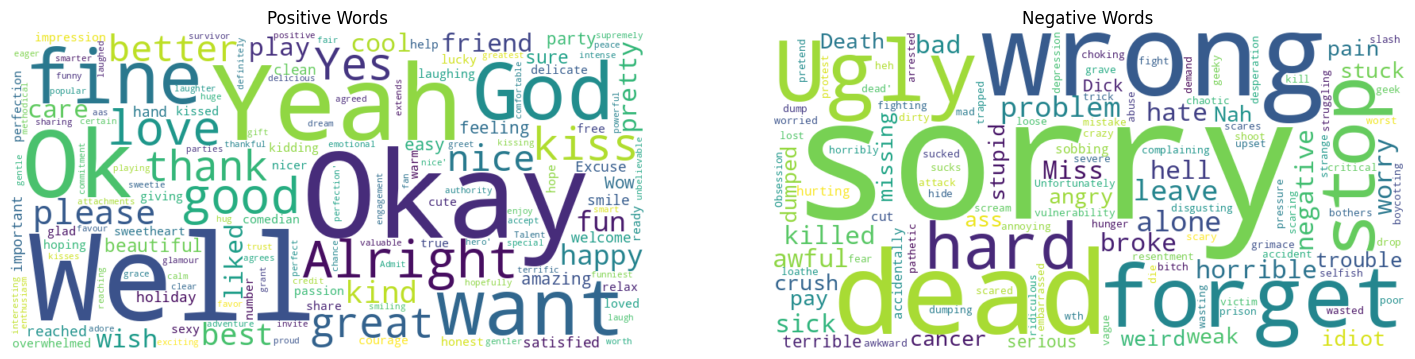

In [31]:
# Function to extract colored words
def extract_colored_words(sentence, color):
    if color == 'green':
        return ' '.join(re.findall(r'<span style="color: green;">(.*?)</span>', sentence))
    elif color == 'red':
        return ' '.join(re.findall(r'<span style="color: red;">(.*?)</span>', sentence))

# Apply the function to extract green and red words
df['Green_words'] = df['Sentence_colored'].apply(lambda x: extract_colored_words(x, 'green'))
df['Red_words'] = df['Sentence_colored'].apply(lambda x: extract_colored_words(x, 'red'))

# Combine all green words and red words
green_text = ' '.join(df['Green_words'].dropna())
red_text = ' '.join(df['Red_words'].dropna())

# Generate word clouds
wordcloud_green = WordCloud(width=800, height=400, background_color='white').generate(green_text)
wordcloud_red = WordCloud(width=800, height=400, background_color='white').generate(red_text)

# Plot the word clouds
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_green, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_red, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words')

plt.show()

#### The word clouds depict the most common positive and negative words used by characters. Positive words include "well," "want," "okay," "good," and "fine," indicating frequent expressions of agreement and affirmation. Negative words such as "sorry," "wrong," "dead," "hard," and "forget" highlight common themes of apology, error, and difficulty. The size of the words reflects their frequency, with larger words appearing more often in the dialogues.

## 1.3 VADER MODEL ACCURACY

In [32]:
#Manually labelled dataset (Positive, Negative, neutral)
data = pd.read_csv('Manual_label_sentiment.csv')
data.head()

,Sentence,Person,True_sentiment
0,There's nothing to tell! He's just some guy I ...,Monica,Neutral
1,All right Joey be nice So does he have a hump?...,Chandler,Neutral
2,Just 'cause I don't want her to go through wha...,Phoebe,Positive
3,All of a sudden the phone starts to ring Now I...,Chandler,Neutral
4,Finally I figure I'd better answer it and it t...,Chandler,Negative


Overall Accuracy: 0.38
Classification Report:
               precision    recall  f1-score   support

    Positive       0.40      0.45      0.43       115
     Neutral       0.79      0.27      0.40       353
    Negative       0.20      0.78      0.32        78

    accuracy                           0.38       546
   macro avg       0.47      0.50      0.38       546
weighted avg       0.62      0.38      0.39       546

Confusion Matrix:
 [[ 61   7  10]
 [192  94  67]
 [ 45  18  52]]


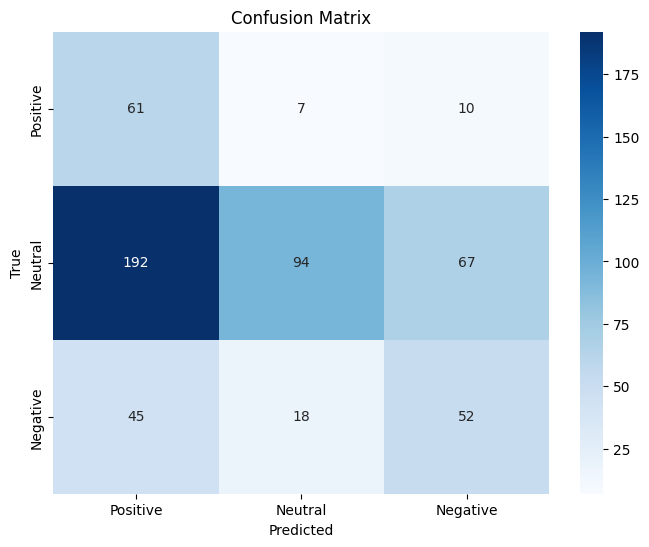

In [33]:
# Extract ground truth and model predictions
y_true = data['True_sentiment']
y_pred = df['Sentiment']

# Calculate overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Overall Accuracy: {accuracy:.2f}')

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Positive', 'Neutral', 'Negative'])
print('Classification Report:\n', report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['Positive', 'Neutral', 'Negative'])
print('Confusion Matrix:\n', cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### The model's overall accuracy is 38%, indicating that it correctly classifies the sentiments about 38% of the time. The f1-scores for each sentiment category highlight some performance disparities: positive sentiments have an f1-score of 0.43, neutral sentiments 0.40, and negative sentiments 0.32. The relatively low f1-scores suggest that the model struggles with balancing precision and recall, particularly for neutral and negative sentiments. This imbalance indicates that while the model might be good at identifying certain sentiments, it often misclassifies others, impacting its reliability.

#### This confusion matrix shows the performance of a classification model on three sentiment categories: Positive, Neutral, and Negative. The highest number in the matrix (192) represents the model's incorrect predictions where Neutral sentiments were classified as Positive, while the lowest (7) indicates incorrect predictions where Positive sentiments were classified as Neutral. Additionally, the number 94 indicates the correct predictions for the Neutral class, which, despite being the highest correct classification, still shows significant room for improvement. The model seems to struggle the most with distinguishing Neutral sentiments, often misclassifying them as Positive.

## 1.4 SVM MODEL

Since, I got low accuracy using VADER Model, hence I implemented an SVM model with TF-IDF feature extraction and applied SMOTE to handle data imbalance. I also evaluated the SVM model's accuracy against a manually labeled dataset, classifying sentiments into Positive, Negative, and Neutral categories.

**SMOTE (Synthetic Minority Over-sampling Technique)** works by creating new, similar data points for the less common class in a dataset to balance it out. Instead of just copying existing data points, SMOTE looks at a data point in the minority class and its closest neighbors, then creates new, slightly different data points between them. This helps models learn better when there’s an imbalance between classes, like when there are more negative sentiments than positive ones. Additionally, TF-IDF captures the importance of words and helps in distinguishing between different documents by assigning weights to terms.

*Implementation of SVM (TF-IDF) & SMOTE on my text:*

##### Feature Extraction and Model Training:

1. **TF-IDF Vectorization:** I transformed the textual data into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency) to capture the importance of words in the dialogues.

2. **SVM Model:** I trained an SVM (Support Vector Machine) model on the TF-IDF features to classify sentiments into Positive, Negative, or Neutral.

3. **Handling Data Imbalance - SMOTE (Synthetic Minority Over-sampling Technique):** I applied SMOTE to generate synthetic samples for underrepresented sentiment classes, ensuring a balanced dataset for training the SVM model.

4. **Model Evaluation:** I evaluated the SVM model's performance using accuracy, classification reports, and confusion matrices to understand how well it classified sentiments compared to the manually labeled data.
Comparison: I compared the performance of the SVM model with the VADER model to determine if the improvements in accuracy were significant.

## 1.5 ML MODEL (SVM) WITH TF-IDF FEATURE EXTRACTION

In [34]:
#Manually labelled dataset (Positive, Negative, neutral)
data = pd.read_csv('Manual_label_sentiment.csv')
data.head()

,Sentence,Person,True_sentiment
0,There's nothing to tell! He's just some guy I ...,Monica,Neutral
1,All right Joey be nice So does he have a hump?...,Chandler,Neutral
2,Just 'cause I don't want her to go through wha...,Phoebe,Positive
3,All of a sudden the phone starts to ring Now I...,Chandler,Neutral
4,Finally I figure I'd better answer it and it t...,Chandler,Negative


In [35]:
data['True_sentiment'].value_counts()

,count
True_sentiment,
Neutral,353
Negative,115
Positive,78


## 1.6 SMOTE

Due to significant data imbalance between the categories, I’m using SMOTE to balance the dataset.

In [36]:
X = data['Sentence']
y = data['True_sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Vectorize text data
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Apply SMOTE to the vectorized training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

# 1.7 SVM MODEL ACCURACY

Accuracy: 0.5365853658536586
Classification Report:
              precision    recall  f1-score   support

    Negative       0.21      0.15      0.17        34
     Neutral       0.65      0.77      0.70       105
    Positive       0.13      0.08      0.10        25

    accuracy                           0.54       164
   macro avg       0.33      0.33      0.33       164
weighted avg       0.48      0.54      0.50       164



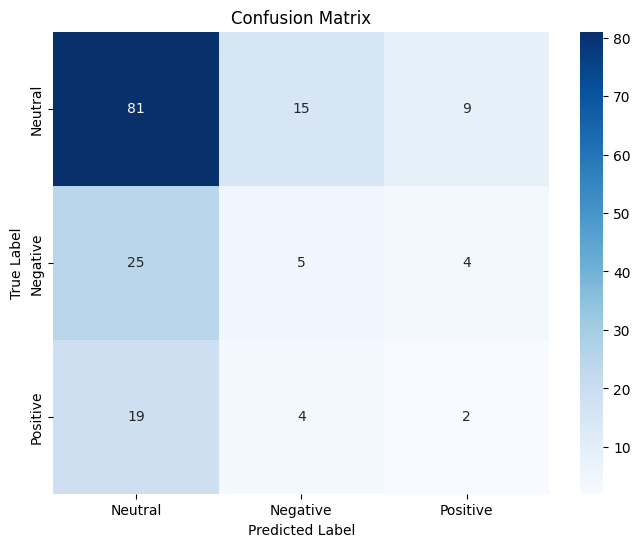

In [37]:
# Train SVM
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = svm_model.predict(X_test_vec)

# Evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=['Neutral', 'Negative', 'Positive'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Neutral', 'Negative', 'Positive'],
            yticklabels=['Neutral', 'Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### The classification report shows an overall accuracy of 54%, with the Neutral class having the highest F1-score of 0.70, indicating better performance compared to the Negative and Positive classes, which have much lower F1-scores of 0.17 and 0.10, respectively.

#### In the confusion matrix, the model correctly predicted Neutral sentiments most often (81 times), but struggled with Positive sentiments, correctly predicting only 2 out of 25 instances. This suggests that while the model does relatively well with Neutral sentiments, it has difficulty accurately identifying Negative and Positive ones.

## Comparison of VADER Model against ML (SVM) Model with TF-IDF & SMOTE
1. The SVM model shows better overall accuracy (54%) and excels in classifying Neutral sentiments as compared to VADER Model (38%).
2. The VADER model has better performance in classifying Positive and Negative sentiments.
3. The SVM model with TF-IDF and SMOTE offers a more balanced weighted average F1 score, indicating better performance across all classes.
4. SVM clearly performed better than VADER because of TF-IDF feature extraction & SMOTE
5. I also could have experimented with different feature extraction methods or combine multiple features (e.g., TF-IDF and word embeddings), further tuning of the SVM hyperparameters (C, gamma, kernel) which could have potentially improved both Model's performance.

# RQ2: Do antagonistic or conflict scenes in "Friends" feature a higher frequency of negative sentiment words?

#### I examined scenes that involve conflict or antagnism and compare the frequency of negative sentiment words in scenes. The findings will reveal if negative language is more prevalent in moments of tension.

In [38]:
dataframe = pd.DataFrame(df['Sentence'])
dataframe.head()

,Sentence
0,There's nothing to tell! He's just some guy I ...
1,All right Joey be nice So does he have a hump?...
2,Just 'cause I don't want her to go through wha...
7,All of a sudden the phone starts to ring Now I...
8,Finally I figure I'd better answer it and it t...


In [39]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk


nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment score
def get_sentiment_score(sentence):
    return sia.polarity_scores(sentence)['compound']

dataframe['Sentiment Score'] = dataframe['Sentence'].apply(get_sentiment_score)
# Assume high absolute sentiment score indicates conflict
dataframe['Potential Conflict'] = dataframe['Sentiment Score'].abs() > 0.5
dataframe.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Sentence,Sentiment Score,Potential Conflict
0,There's nothing to tell! He's just some guy I ...,0.0000,False
1,All right Joey be nice So does he have a hump?...,0.4871,False
2,Just 'cause I don't want her to go through wha...,-0.1316,False
7,All of a sudden the phone starts to ring Now I...,0.0000,False
8,Finally I figure I'd better answer it and it t...,0.3595,False


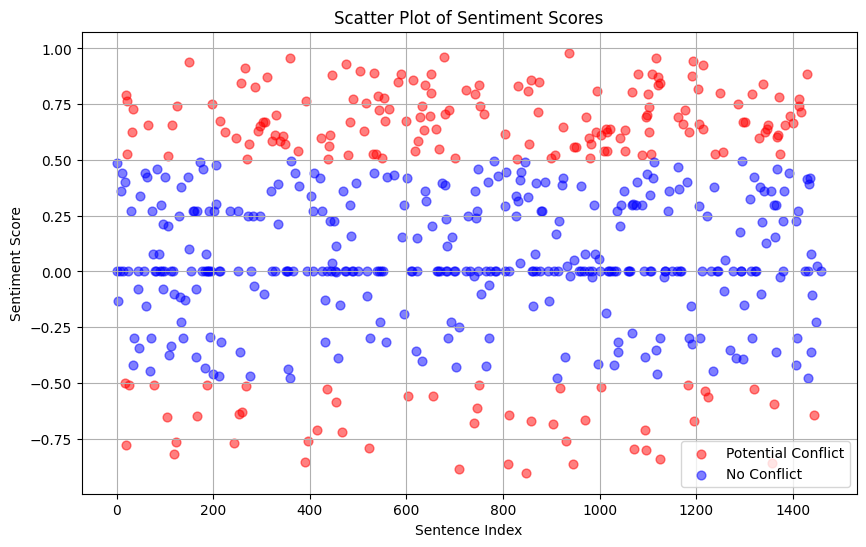

In [40]:
colors = ['red' if val else 'blue' for val in dataframe['Sentiment Score'].abs() > 0.5]

plt.figure(figsize=(10, 6))

# Scatter plot for 'Potential Conflict'
plt.scatter(dataframe.index[dataframe['Sentiment Score'].abs() > 0.5],
            dataframe['Sentiment Score'][dataframe['Sentiment Score'].abs() > 0.5],
            color='red', label='Potential Conflict', s=40, alpha=0.5)

# Scatter plot for 'No Conflict'
plt.scatter(dataframe.index[dataframe['Sentiment Score'].abs() <= 0.5],
            dataframe['Sentiment Score'][dataframe['Sentiment Score'].abs() <= 0.5],
            color='blue', label='No Conflict', s=40, alpha=0.5)

plt.title("Scatter Plot of Sentiment Scores")
plt.xlabel("Sentence Index")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.legend()
plt.show()


In [41]:
# Calculate percentage of negative sentiment in potential conflict and non-conflict scenes
conflict_stats = dataframe[dataframe['Potential Conflict']]['Sentiment Score'].mean()
non_conflict_stats = dataframe[~dataframe['Potential Conflict']]['Sentiment Score'].mean()

print(f"Average sentiment score in potential conflict scenes: {conflict_stats:.2f}")
print(f"Average sentiment score in non-conflict scenes: {non_conflict_stats:.2f}")

Average sentiment score in potential conflict scenes: 0.37
Average sentiment score in non-conflict scenes: 0.06


In [42]:
from nltk.tokenize import word_tokenize
from nltk.corpus import opinion_lexicon
from nltk import download


download('opinion_lexicon')

# Load negative words from the opinion lexicon
negative_words = set(opinion_lexicon.negative())
def count_negative_words(sentence):
    words = word_tokenize(sentence.lower())
    return sum(1 for word in words if word in negative_words)

dataframe['Negative Word Count'] = dataframe['Sentence'].apply(count_negative_words)

# Analyze negative word count by conflict classification
conflict_negative_count = dataframe[dataframe['Potential Conflict']]['Negative Word Count'].mean()
non_conflict_negative_count = dataframe[~dataframe['Potential Conflict']]['Negative Word Count'].mean()

print(f"Average negative word count in potential conflict scenes: {conflict_negative_count:.2f}")
print(f"Average negative word count in non-conflict scenes: {non_conflict_negative_count:.2f}")


[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


Average negative word count in potential conflict scenes: 0.58
Average negative word count in non-conflict scenes: 0.30


Yes, based on my analysis, conflict scenes do feature a higher frequency of negative sentiment words. Potential conflict scenes have a higher average count of negative words compared to non-conflict scenes. Thus, the higher average negative word count in conflict scenes aligns with the expectation that conflict or antagonistic scenes would contain more negative sentiment.

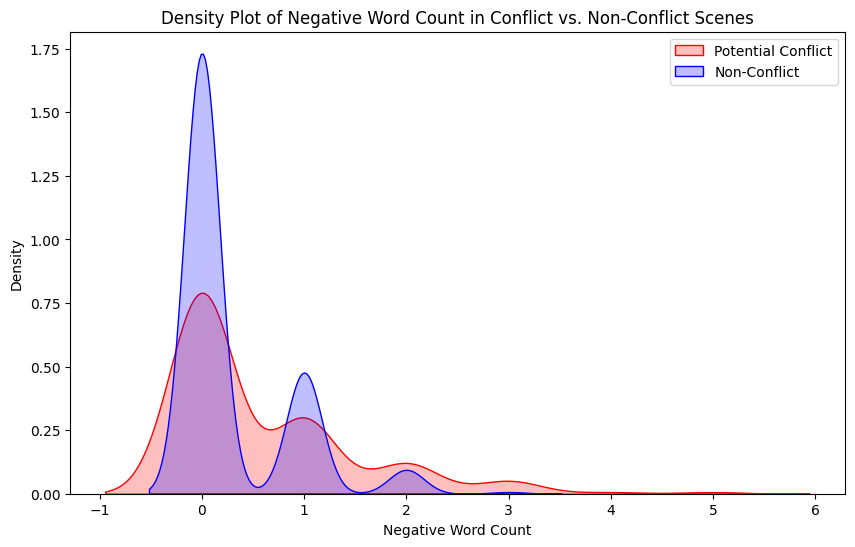

In [43]:
plt.figure(figsize=(10, 6))

# Plot density plots for conflict and non-conflict scenes
sns.kdeplot(data=dataframe[dataframe['Potential Conflict']]['Negative Word Count'], color='red', label='Potential Conflict', fill=True)
sns.kdeplot(data=dataframe[~dataframe['Potential Conflict']]['Negative Word Count'], color='blue', label='Non-Conflict', fill=True)

plt.title('Density Plot of Negative Word Count in Conflict vs. Non-Conflict Scenes')
plt.xlabel('Negative Word Count')
plt.ylabel('Density')
plt.legend()
plt.show()


# ADDITIONAL ANALYSIS - TEXT SUMMARIZATION USING BART MODEL

I have used the pre-trained **BART** model to effectively generate concise and coherent **abstractive summaries** of lengthy dialogue scenes from the Friends series, capturing the essential information while reducing the text length significantly.

**BART (Bidirectional and Auto-Regressive Transformers)** is a powerful model developed by Facebook AI for tasks like text summarization, translation, and text generation. It is called "Bidirectional and Auto-Regressive Transformers" because it incorporates two different methods for processing and generating text making the text contextually relevant, coherent and flexible.
  - **Bidirectional:** It means that the model reads the text from both directions—left-to-right and right-to-left (encoding stage).
  - **Auto-regressive:** It means that the model generates text one word at a time, using the previously generated words to predict the next word, starting with a special `start` token (decoding stage).

**Implementation of BART on my text :**

1. **Filtering Long Sentences:** Selecting subtitles that are longer than 250 characters (so that the model runs smoothly).
2. **Combining Text:** Merging these selected subtitles into a single string.
3. **BART Model Flow:**
  - Import libraries from `transformers` package -
    - `BartTokenizer` - encoding and decoding text
    - `BartForConditionalGeneration` - BART model used for generating summaries.
  - Load Pre-trained BART Model and Tokenizer
  - Tokenize and Encode the Text
  - Generate Summary
  - Decode the Summary

Below is a basic flow of the working of BART Model (for simplicity I have used "The quick brown fox jumps over the lazy dog" text) :-

                       +-----------------------------+
                       |                             |
                       |     STEP 1: INPUT TEXT      |        
                       |    "The quick brown fox     |
                       |  jumps over the lazy dog."  |
                       |                             |
                       +-------------+---------------+
                                     |
                                     |
                                     V
                       +-----------------------------+
                       |                             |
                       |   STEP 2: PRE-TRAINING      |
                       |       (CORRUPTION)          |
                       |                             |
                       |     Corrupt Sentence:       |
                       |   "The quick [MASK] fox     |
                       |   jumps over the lazy dog." |
                       |                             |
                       |  (Model learns to predict   |
                       | 'brown' based on context.)  |
                       +-------------+---------------+
                                     |
                                     |
                                     V
                       +-----------------------------+
                       |                             |
                       |      STEP 3: ENCODING       |  
                       |                             |
                       |   Encoder Reads Sentence:   |
                       |    "The quick brown fox     |
                       |  jumps over the lazy dog."  |
                       |                             |
                       |   Converts to Vectors:      |
                       |   [1, 2, 3], [4, 5, 6], .   |
                       |                             |
                       +-------------+---------------+
                                     |
                                     |
                                     V
                       +-----------------------------+
                       |                             |
                       |      STEP 4: DECODING       |
                       |                             |
                       |    Decoder Generates Text   |
                       |        Word by Word:        |
                       |   Start -> The -> quick ->  |
                       |   brown -> fox -> jumps ->  |
                       |   over -> the -> lazy -> dog|
                       |                             |
                       +-------------+---------------+
                                     |
                                     |
                                     V
                       +-----------------------------+
                       |                             |
                       |       STEP 5: SUMMARY       |
                       |      "A fast fox leaps      |
                       |       over a lazy dog."     |
                       |                             |
                       +-----------------------------+


In [44]:
text_summary = df[df['Sentence'].str.len() > 250]
combined_text = ' '.join(text_summary['Sentence'].tolist())
combined_text

"Barry I'm sorry I am so sorry I know you probably think that this is all about what I said the other day about you making love with your socks on but it isn't it isn't it's about me and I ju She stops talking and dials the phone Hi machine cut me off again anywaylook look I know that some girl is going to be incredibly lucky to become Mrs Barry Finkel but it isn't me it's not me And not that I have any idea who me is right now but you just have to give me a chance too You're welcome I remember when I first came to this city I was fourteen My mom had just killed herself and my stepdad was back in prison and I got here and I didn't know anybody And I ended up living with this albino guy who was like cleaning windshields outside port authority and then he killed himself and then I found aromatherapy So believe me I know exactly how you feel Hi Mindy Hi itit's Rachel Yeah I'm fine II saw Barry today Oh yeah yeah hehe told me No no it's okay I hope you two are very happy I really do Oh oh 

In [45]:
# Load pre-trained BART (Bidirectional and Auto-Regressive Transformers) model and tokenizer
model_name = 'facebook/bart-large-cnn'
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Tokenize and encode the subtitle text
inputs = tokenizer.encode("summarize: " + combined_text, return_tensors="pt", max_length=1024, truncation=True)

# Generate summary
summary_ids = model.generate(inputs, max_length=500, min_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Print and/or return the summary
print(summary)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Barry Finkel and Aurora Finkel have been dating for a few months. He says he's very thankful that all of your Thanksgivings sucked. He hopes they have his old hairline and your old nose. He proposes a toast to their relationship. She says no, she doesn't want him to say that. "I know it was a cheap shot but I feel so much better now No no resentment believe me it's worth it" "For me gum is perfection I loathe myself I'd like to propose a toast Little toast here ding ding" "I hope you two are very happy I really do" "If you'd gone to Vail and if you'd been with your family if you didn't have syphilis and stuff we wouldn't be all together"


In [46]:
# Example summary text
summary_text = """
Barry Finkel and Aurora Finkel have been dating for a few months. He says he's very thankful that all of your Thanksgivings sucked.
He hopes they have his old hairline and your old nose. He proposes a toast to their relationship.
She says no, she doesn't want him to say that. I know it was a cheap shot but I feel so much better
now No no resentment believe me it's worth it. For me gum is perfection I loathe myself I'd like to
propose a toast Little toast here. I hope you two are very happy
I really do If you'd gone to Vail and if you'd been with your family if you didn't have syphilis
and stuff we wouldn't be all together.
"""

# Print the summary text
print(summary_text)


Barry Finkel and Aurora Finkel have been dating for a few months. He says he's very thankful that all of your Thanksgivings sucked.
He hopes they have his old hairline and your old nose. He proposes a toast to their relationship.
She says no, she doesn't want him to say that. I know it was a cheap shot but I feel so much better
now No no resentment believe me it's worth it. For me gum is perfection I loathe myself I'd like to
propose a toast Little toast here. I hope you two are very happy
I really do If you'd gone to Vail and if you'd been with your family if you didn't have syphilis
and stuff we wouldn't be all together.



#### `summary_text` is an abstractive summary of the text (subtitles). The model has effectively shortened the text and produced a concise summary.